# Predict prices of vehicles

Here [vehicle_prices](https://www.kaggle.com/akashsdas/vehicle-prices) is used to perform `EDA`, find features by `feature engineering` that affects `price` of vehicles and create a `regression` model that can predict price of vechicles.

**While doing this we'll go through**

- Feature engineering on `categorical` and `continuous` features
- Dealing with `multi-collinearity` issues
- Dealing with `outliers`

![](https://media.giphy.com/media/KhC9pEXTWrys8/giphy.gif)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, zscore
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump, load

In [2]:
# Pandas config
def pandas_config():
    # display 10 rows and all the columns
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', None)


pandas_config()

In [3]:
# Load dataset
def load_dataset():
    return pd.read_csv('/kaggle/input/vehicle-prices/data.csv')


df = load_dataset()
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 205


,Unnamed: 0,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
103,103,0,108,nissan,gas,std,four,sedan,fwd,front,100.4,184.6,66.5,55.1,3060,ohcv,six,181,mpfi,3.43,3.27,9.0,152,5200,19,25,13499
13,13,0,188,bmw,gas,std,four,sedan,rwd,front,101.2,176.8,64.8,54.3,2765,ohc,six,164,mpfi,3.31,3.19,9.0,121,4250,21,28,21105
9,9,0,?,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,52.0,3053,ohc,five,131,mpfi,3.13,3.40,7.0,160,5500,16,22,?
130,130,0,?,renault,gas,std,four,wagon,fwd,front,96.1,181.5,66.5,55.2,2579,ohc,four,132,mpfi,3.46,3.90,8.7,?,?,23,31,9295
116,116,0,161,peugot,diesel,turbo,four,sedan,rwd,front,107.9,186.7,68.4,56.7,3252,l,four,152,idi,3.70,3.52,21.0,95,4150,28,33,17950


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         205 non-null    int64  
 1   symboling          205 non-null    int64  
 2   normalized-losses  205 non-null    object 
 3   make               205 non-null    object 
 4   fuel-type          205 non-null    object 
 5   aspiration         205 non-null    object 
 6   num-of-doors       205 non-null    object 
 7   body-style         205 non-null    object 
 8   drive-wheels       205 non-null    object 
 9   engine-location    205 non-null    object 
 10  wheel-base         205 non-null    float64
 11  length             205 non-null    float64
 12  width              205 non-null    float64
 13  height             205 non-null    float64
 14  curb-weight        205 non-null    int64  
 15  engine-type        205 non-null    object 
 16  num-of-cylinders   205 non

## Data Preparation

The info above is telling that there are nan's in our dataset, but this does not means that we don't have any missing data. Columns like `bore`, `stroke`, `normalized-losses` & might be others having their missing data in the form of ? (question-mark), so replacing the ? with np.nan

In [5]:
print(f"Before: {df['normalized-losses'].unique()}\n")
df.replace('?', np.nan, inplace=True)
print(f"After: {df['normalized-losses'].unique()}\n")

df.info()

Before: ['?' '164' '158' '192' '188' '121' '98' '81' '118' '148' '110' '145' '137'
 '101' '78' '106' '85' '107' '104' '113' '150' '129' '115' '93' '142'
 '161' '153' '125' '128' '122' '103' '168' '108' '194' '231' '119' '154'
 '74' '186' '83' '102' '89' '87' '77' '91' '134' '65' '197' '90' '94'
 '256' '95']

After: [nan '164' '158' '192' '188' '121' '98' '81' '118' '148' '110' '145' '137'
 '101' '78' '106' '85' '107' '104' '113' '150' '129' '115' '93' '142'
 '161' '153' '125' '128' '122' '103' '168' '108' '194' '231' '119' '154'
 '74' '186' '83' '102' '89' '87' '77' '91' '134' '65' '197' '90' '94'
 '256' '95']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         205 non-null    int64  
 1   symboling          205 non-null    int64  
 2   normalized-losses  164 non-null    object 
 3   make               205 non-null

In [6]:
# Get list of names of columns that contains nan in df
def get_nan_columns(df):
    return df.columns[df.isna().any()].tolist()


nan_columns = get_nan_columns(df)
print(f'Columns that contains NaN values: {nan_columns}\n')

df[nan_columns].info()

Columns that contains NaN values: ['normalized-losses', 'num-of-doors', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   normalized-losses  164 non-null    object
 1   num-of-doors       203 non-null    object
 2   bore               201 non-null    object
 3   stroke             201 non-null    object
 4   horsepower         203 non-null    object
 5   peak-rpm           203 non-null    object
 6   price              201 non-null    object
dtypes: object(7)
memory usage: 11.3+ KB


In [7]:
def change_dtypes(df, _from=['object'], to='float'):
    columns = df.select_dtypes(include=_from).columns.tolist()
    for column in columns:
        # duck typing
        try:
            # This will fail when the column cannot be converted to 
            # float which means the column has non number values
            df[column] = df[column].astype(to)
            
            # columns successfully changed dtype
            print(column, end=', ')
        except ValueError:
            continue
            

change_dtypes(df)

normalized-losses, bore, stroke, horsepower, peak-rpm, price, 

In [8]:
# Setting missing values as average
def replace_missing_values_with_mean(df, column_name):
    df[column_name].fillna(df[column_name].mean(), inplace=True)

In [9]:
# Helper plotting functions

# Here `column` means `df[column_name]`

def plot_histplot(column):
    sns.histplot(x=column, color='#65b87b', alpha=.7) 

    
def plot_scatterplot(x_column, y_column):
    sns.scatterplot(x=x_column, y=y_column, color='#706dbd', alpha=.7, s=80)
    
    
def plot_countplot(column):
    sns.countplot(x=column, color='#42b0f5', alpha=.7)

Average vehicle price: 13207.13


False

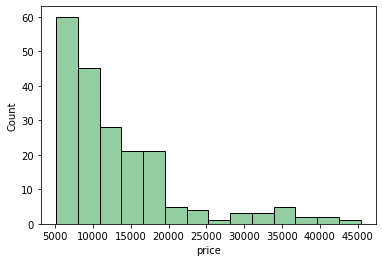

In [10]:
# price

''' Since price column has very few missing cells, we can
    replace those missing values with the average price ''' 

plot_histplot(df.price)

replace_missing_values_with_mean(df, 'price')
print(f'Average vehicle price: {round(df.price.mean(), 2)}')
any(df.price.isnull())

In [11]:
def drop_column(df, column_name, inplace=True):
    return df.drop([column_name], axis='columns', inplace=inplace)


# Dropping column named `Unnamed: 0` as its values are just mirror of df's indexes
drop_column(df, 'Unnamed: 0')

In [12]:
def refactor_continuous_nan_columns(df, column_name, scale_func=None):    
    tmp_not_nan_df = df[~df[column_name].isnull()][[column_name, 'price']]
    pearson_corr = pearsonr(tmp_not_nan_df[column_name], tmp_not_nan_df.price)[0]
    print(f"Pearson corr: {round(pearson_corr, 2)}")
    del tmp_not_nan_df
    
    if pearson_corr >= .5 or pearson_corr <= -.5:
        # moderate correaltion with price
        replace_missing_values_with_mean(df, column_name)
        print(f'Average {column_name} value: {round(df[column_name].mean(), 2)}')
        print(any(df[column_name].isnull()))
                
        if scale_func:
            # `scale_func` is a function and it is added to just scale the column
            # after its average is found (place where this is needed - EDA of 
            # continuous variables)
            df[column_name] = scale_func(df[column_name])
            
        # since if the column has scaled then plot will be created 
        # using the scaled data
        plot_scatterplot(df[column_name], df.price)
    else:
        plot_scatterplot(df[column_name], df.price)        
        
        # Since `column_name` have a very low correlation with prices, so drop the column 
        drop_column(df, column_name)
        print(f'{column_name} has been dropped')   

`refactor_continuous_nan_columns` not only solves the problem of removing nan but also remove columns that have low correlation with `price` column

Pearson corr: 0.2
normalized-losses has been dropped


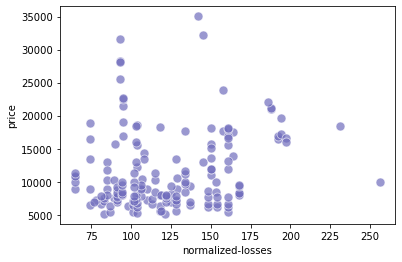

In [13]:
# normalized-losses
refactor_continuous_nan_columns(df, 'normalized-losses')

Most occured num of doors: four


False

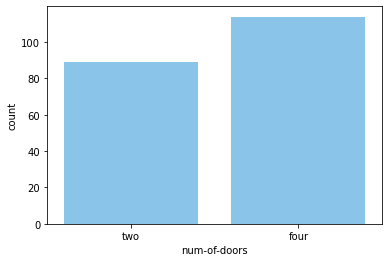

In [14]:
# num-of-doors

''' Since num-of-doors column has very few missing cells, we can
    replace those missing values with the num-of-doors that has 
    occured the most ''' 

plot_countplot(df['num-of-doors'])

# Finding the value that occurs the most
most_occured_num_of_doors = df['num-of-doors'].value_counts().idxmax()
print(f'Most occured num of doors: {most_occured_num_of_doors}')

df['num-of-doors'].replace(np.nan, most_occured_num_of_doors, inplace=True)
any(df['num-of-doors'].isnull())

Pearson corr: 0.53
Average bore value: 3.33
False


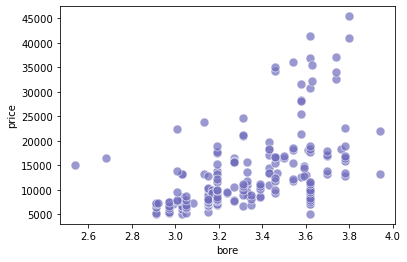

In [15]:
# bore
refactor_continuous_nan_columns(df, 'bore')

Pearson corr: 0.08
stroke has been dropped


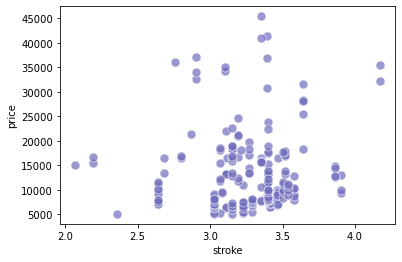

In [16]:
# stroke
refactor_continuous_nan_columns(df, 'stroke')

Pearson corr: 0.76
Average horsepower value: 104.26
False


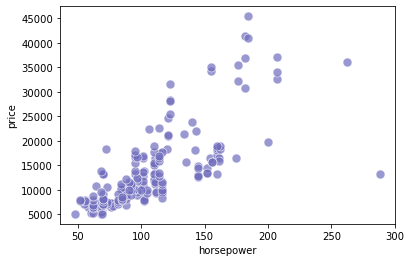

In [17]:
# horsepower
refactor_continuous_nan_columns(df, 'horsepower')

Pearson corr: -0.1
peak-rpm has been dropped


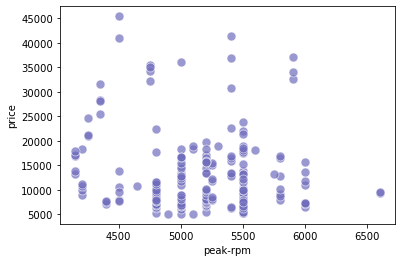

In [18]:
# peak-rpm
refactor_continuous_nan_columns(df, 'peak-rpm')

In [19]:
nan_columns = get_nan_columns(df)
print(f'Columns that contains NaN values: {nan_columns}')

Columns that contains NaN values: []


`Missing values` problem solved

## EDA

Separating df into continous & categorical variables and performing EDA

In [20]:
# Get df with columns having continuous variables
def get_continuous_df(df):
    return df.select_dtypes(exclude=['object'])


# Get df with columns having categorical variables
def get_categorical_df(df):
    return df.select_dtypes(include=['object'])

In [21]:
# Get columns names in as sentence (instead of getting long list 
# of column names)
def get_column_names(df):
    for column_name in df.columns.tolist():
        print(f'{column_name} | ', end='')

While dropping any row, keep the `continuous_df` & `categorical_df` in sync as at the end when the data is prepared these both dfs are going to join to create out main df on which we'll do our EDA.

### Continuous Variables

In [22]:
continuous_df = get_continuous_df(df)
continuous_df.sample(5)

,symboling,wheel-base,length,width,height,curb-weight,engine-size,bore,compression-ratio,horsepower,city-mpg,highway-mpg,price
36,0,96.5,157.1,63.9,58.3,2024,92,2.92,9.2,76.0,30,34,7295.0
174,-1,102.4,175.6,66.5,54.9,2480,110,3.27,22.5,73.0,30,33,10698.0
16,0,103.5,193.8,67.9,53.7,3380,209,3.62,8.0,182.0,16,22,41315.0
105,3,91.3,170.7,67.9,49.7,3139,181,3.43,7.8,200.0,17,23,19699.0
154,0,95.7,169.7,63.6,59.1,2290,92,3.05,9.0,62.0,27,32,7898.0


Just for good comparasion between `features` and `traget` variables I have scaled `price` column in the dataframe, but while creating the machine learning model I have used the not scaled `price` data (which is stored in the original_y variable), this will have no effect on the model since features will be used for prediction and not the target variable and all computational effects depends on features.

In [23]:
original_y = continuous_df[['price']]
original_y.loc[:5]

,price
0,13495.0
1,16500.0
2,16500.0
3,13950.0
4,17450.0
5,15250.0


In [24]:
# Scaling int & float dtype column
def standard_scaler(column):
    # Bumping up the ndim by np.newaxis as column.values is 1D & fit_transform needs 2D
    return StandardScaler().fit_transform(column.values[:, np.newaxis])


# Scaling all int & float dtype columns 
def scaling_df(df):
    # Selecting columns which have number dtype
    numbers_df = df.select_dtypes(include=[np.int64, np.float64])

    for column_name in numbers_df.columns.tolist():
        df[column_name] = standard_scaler(df[column_name])
    return df

In [25]:
continuous_df.price = standard_scaler(continuous_df.price)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Will scale the columns while doing `EDA` for individual column

The strength of the linear association between two variables is quantified by the correlation coefficient. ... Since the formula for calculating the `correlation coefficient` standardizes the variables, changes in `scale or units of measurement will not affect its value`.

In [26]:
get_column_names(continuous_df)

symboling | wheel-base | length | width | height | curb-weight | engine-size | bore | compression-ratio | horsepower | city-mpg | highway-mpg | price | 

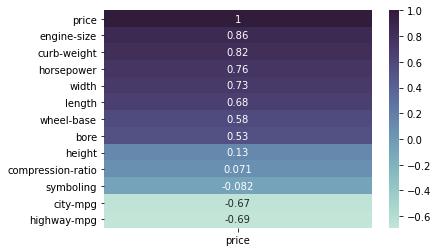

In [27]:
# Pearson correlation of a column with respect to others
def corr_of_a_column(df, column_name, how_many=None, ax=None):
    how_many = len(df) if how_many == None else how_many
    cor = df.corr()[[column_name]].sort_values(
        by=column_name, ascending=False
    )[:how_many]
    sns.heatmap(cor, annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), ax=ax)
    
    
corr_of_a_column(continuous_df, 'price')

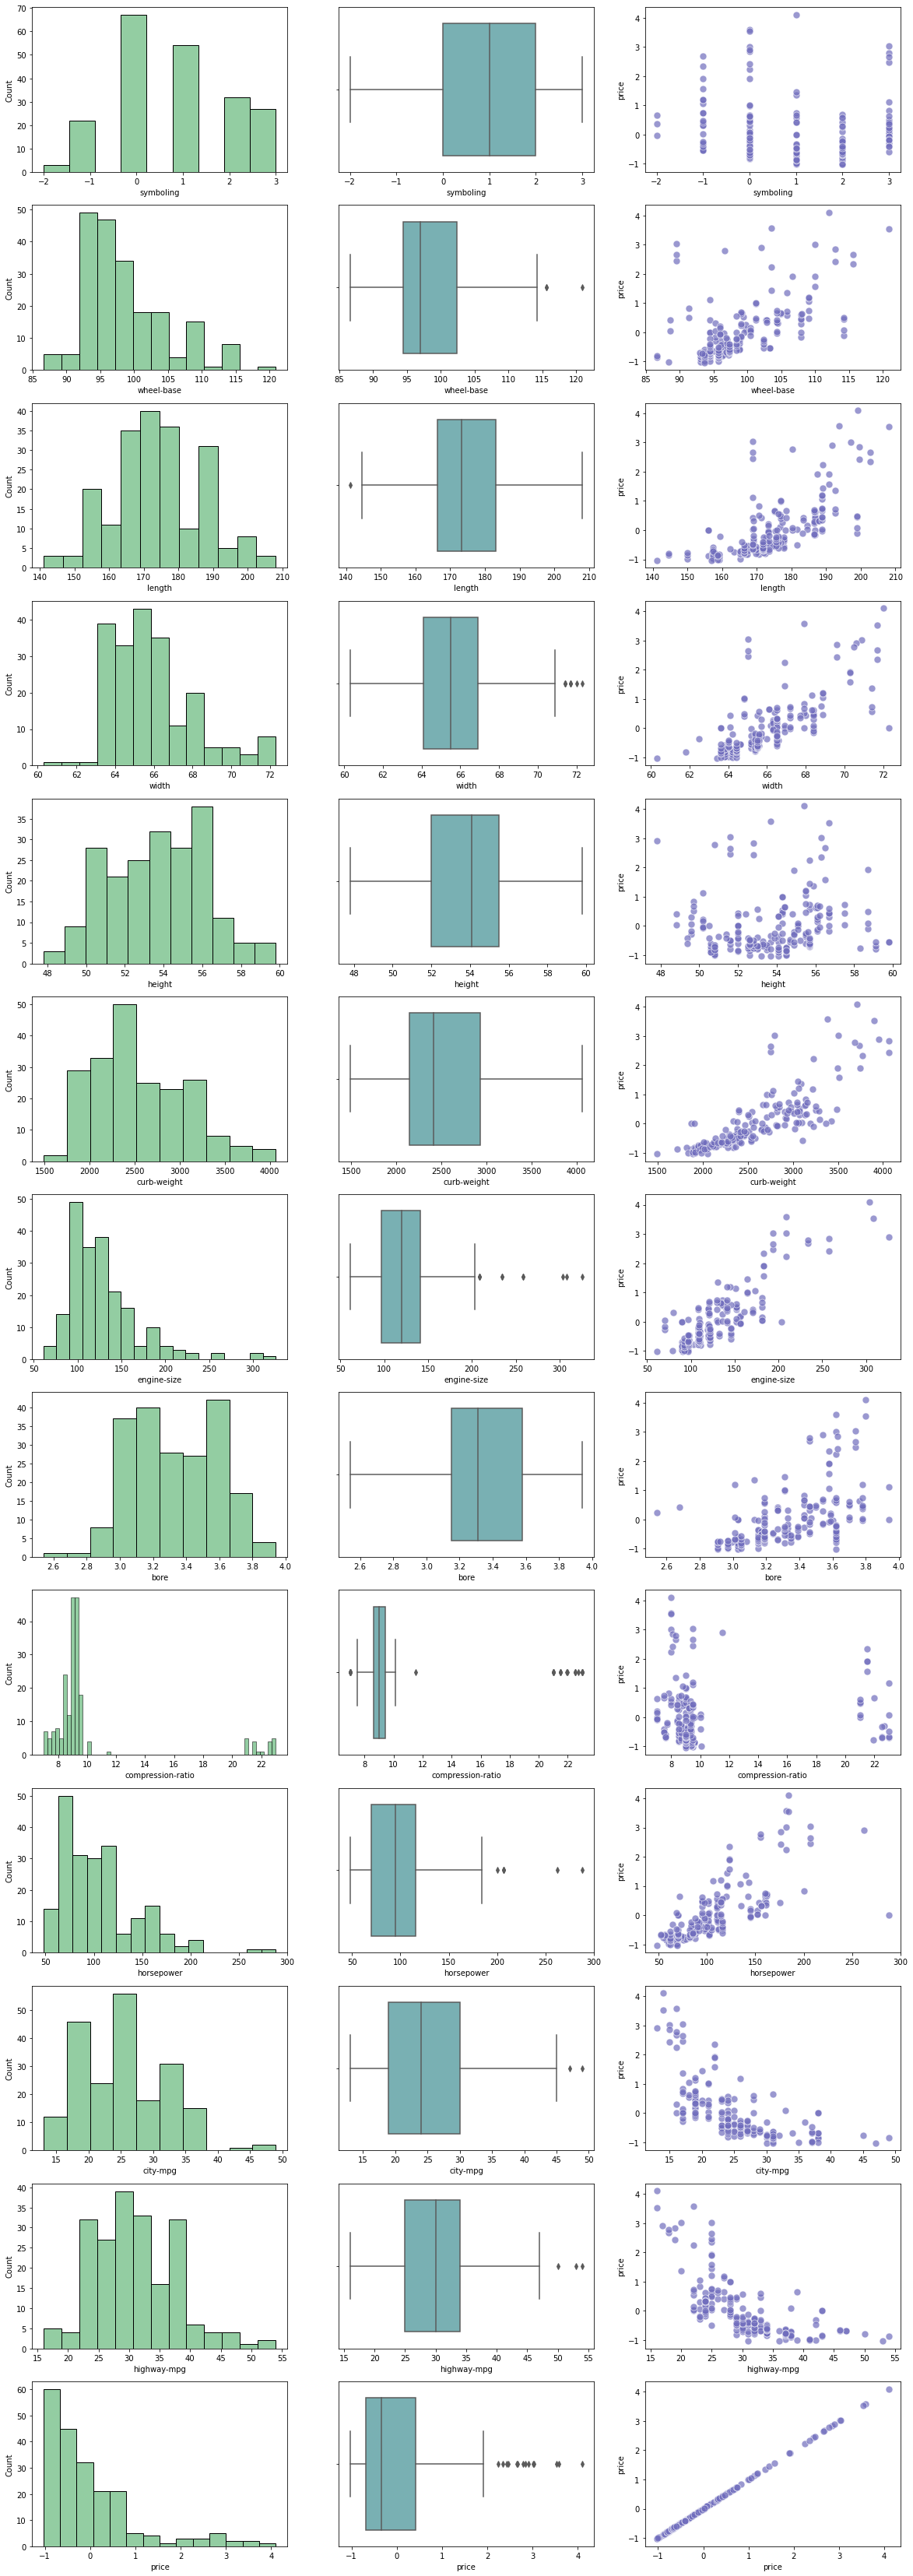

In [28]:
def plot_base_relation(df, figsize=(20, 60)):
    columns = df.columns.tolist()
    _, axs = plt.subplots(len(columns), 3, figsize=figsize)
    
    for idx, column in enumerate(columns):
        # To get distribution of data
        sns.histplot(
            x=df[column],
            kde=False,
            color='#65b87b', alpha=.7,
            ax=axs[idx][0]
        )

        # To get knowledge about outliers
        sns.boxplot(
            x=df[column],
            color='#6fb9bd',
            ax=axs[idx][1]
        )

        # To get its realtion with SalePrice
        sns.scatterplot(
            x=column, y='price', data=df,
            color='#706dbd', alpha=.7, s=80,
            ax=axs[idx][2]
        )
        
        
plot_base_relation(continuous_df)

In [29]:
# Removing outliers using IQR method
def rm_outliers_in_col_using_iqr(df, col):
    # col here is df.column_name (or df[column_name])

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    outliers_row_idx = col.loc[
        (col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR))
    ].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows')
    return (outliers_row_idx, df)


# Removing outliers using the Zscore method
def rm_outliers_in_col_using_zscore(df, col, column_name):
    # col here is df.column_name (or df[column_name])
    
    zscores_df = pd.DataFrame({
        f'{column_name}': col.to_numpy()
    }, df.index.tolist())
    
    zscores_df['zscores'] = zscores_df.apply(lambda x: zscore(x))
    outliers_row_idx = zscores_df[np.abs(zscores_df.zscores) > 3].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows')
    return (outliers_row_idx, df)


# Remove outliers of a column using iqr & zscore methods
def remove_outliers_of_a_column(df, column_name):
    rm_idxs = []
    for _ in range(10):
        outliers_row_idx, df = rm_outliers_in_col_using_iqr(df, df[column_name])
        rm_idxs.extend(outliers_row_idx)
        
        outliers_row_idx, df = rm_outliers_in_col_using_zscore(df, df[column_name], column_name)
        rm_idxs.extend(outliers_row_idx)
    return rm_idxs, df


# Remove outliers of a df using iqr & zscore methods
def remove_outliers_of_df(df):
    rm_rows_idxs = []
    for column in df.columns.tolist():
        if column == 'price':
            # As we don't want to do anything with `SalePrice`
            continue
            
        rm_idxs, df = remove_outliers_of_a_column(df, column)
        rm_rows_idxs.extend(rm_idxs)
    return rm_rows_idxs, df

In [30]:
# To do the above thing we can just modify the `remove_outliers_of_df` func
def remove_outliers_of_df_with_threshold(df, threshold=4):
    # `threshold` here is the percent above which the entire 
    # column will be dropped 

    rm_rows_idxs = []
    for column in df.columns.tolist():
        if column == 'price':
            # As we don't want to do anything with `price`
            continue
            
        rm_idxs, tmp_df = remove_outliers_of_a_column(df, column)

        if round(len(rm_idxs) / len(df), 2) * 100 > threshold:
            drop_column(df, column)
        else:
            df = tmp_df.copy()
            del tmp_df
            rm_rows_idxs.extend(rm_idxs)
   
    return rm_rows_idxs, df



with np.errstate(divide='ignore', invalid='ignore'):
    # /opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
    #  return (a - mns) / sstd
    # 
    # To avoid the above error which happens while calculating the zscore as std(sstd) vanishes => (a - mns) / sstd
    
    print('=== Old df info ===')
    print(continuous_df.info())
    
    RM_ROWS_IDXS, continuous_df = remove_outliers_of_df_with_threshold(continuous_df)
    
    print('\n=== New df info ===\n')
    print(continuous_df.info())

=== Old df info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    int64  
 6   engine-size        205 non-null    int64  
 7   bore               205 non-null    float64
 8   compression-ratio  205 non-null    float64
 9   horsepower         205 non-null    float64
 10  city-mpg           205 non-null    int64  
 11  highway-mpg        205 non-null    int64  
 12  price              205 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 20.9 KB
None

=== New df info ===

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 204
Data 

In [31]:
print(f'{len(RM_ROWS_IDXS)} columns are dropped while removing outliers')

18 columns are dropped while removing outliers


In [32]:
print(len(original_y))

# Dropping rows in `original_y`
original_y.drop(RM_ROWS_IDXS, axis='rows', inplace=True)
print(len(original_y))

205
187


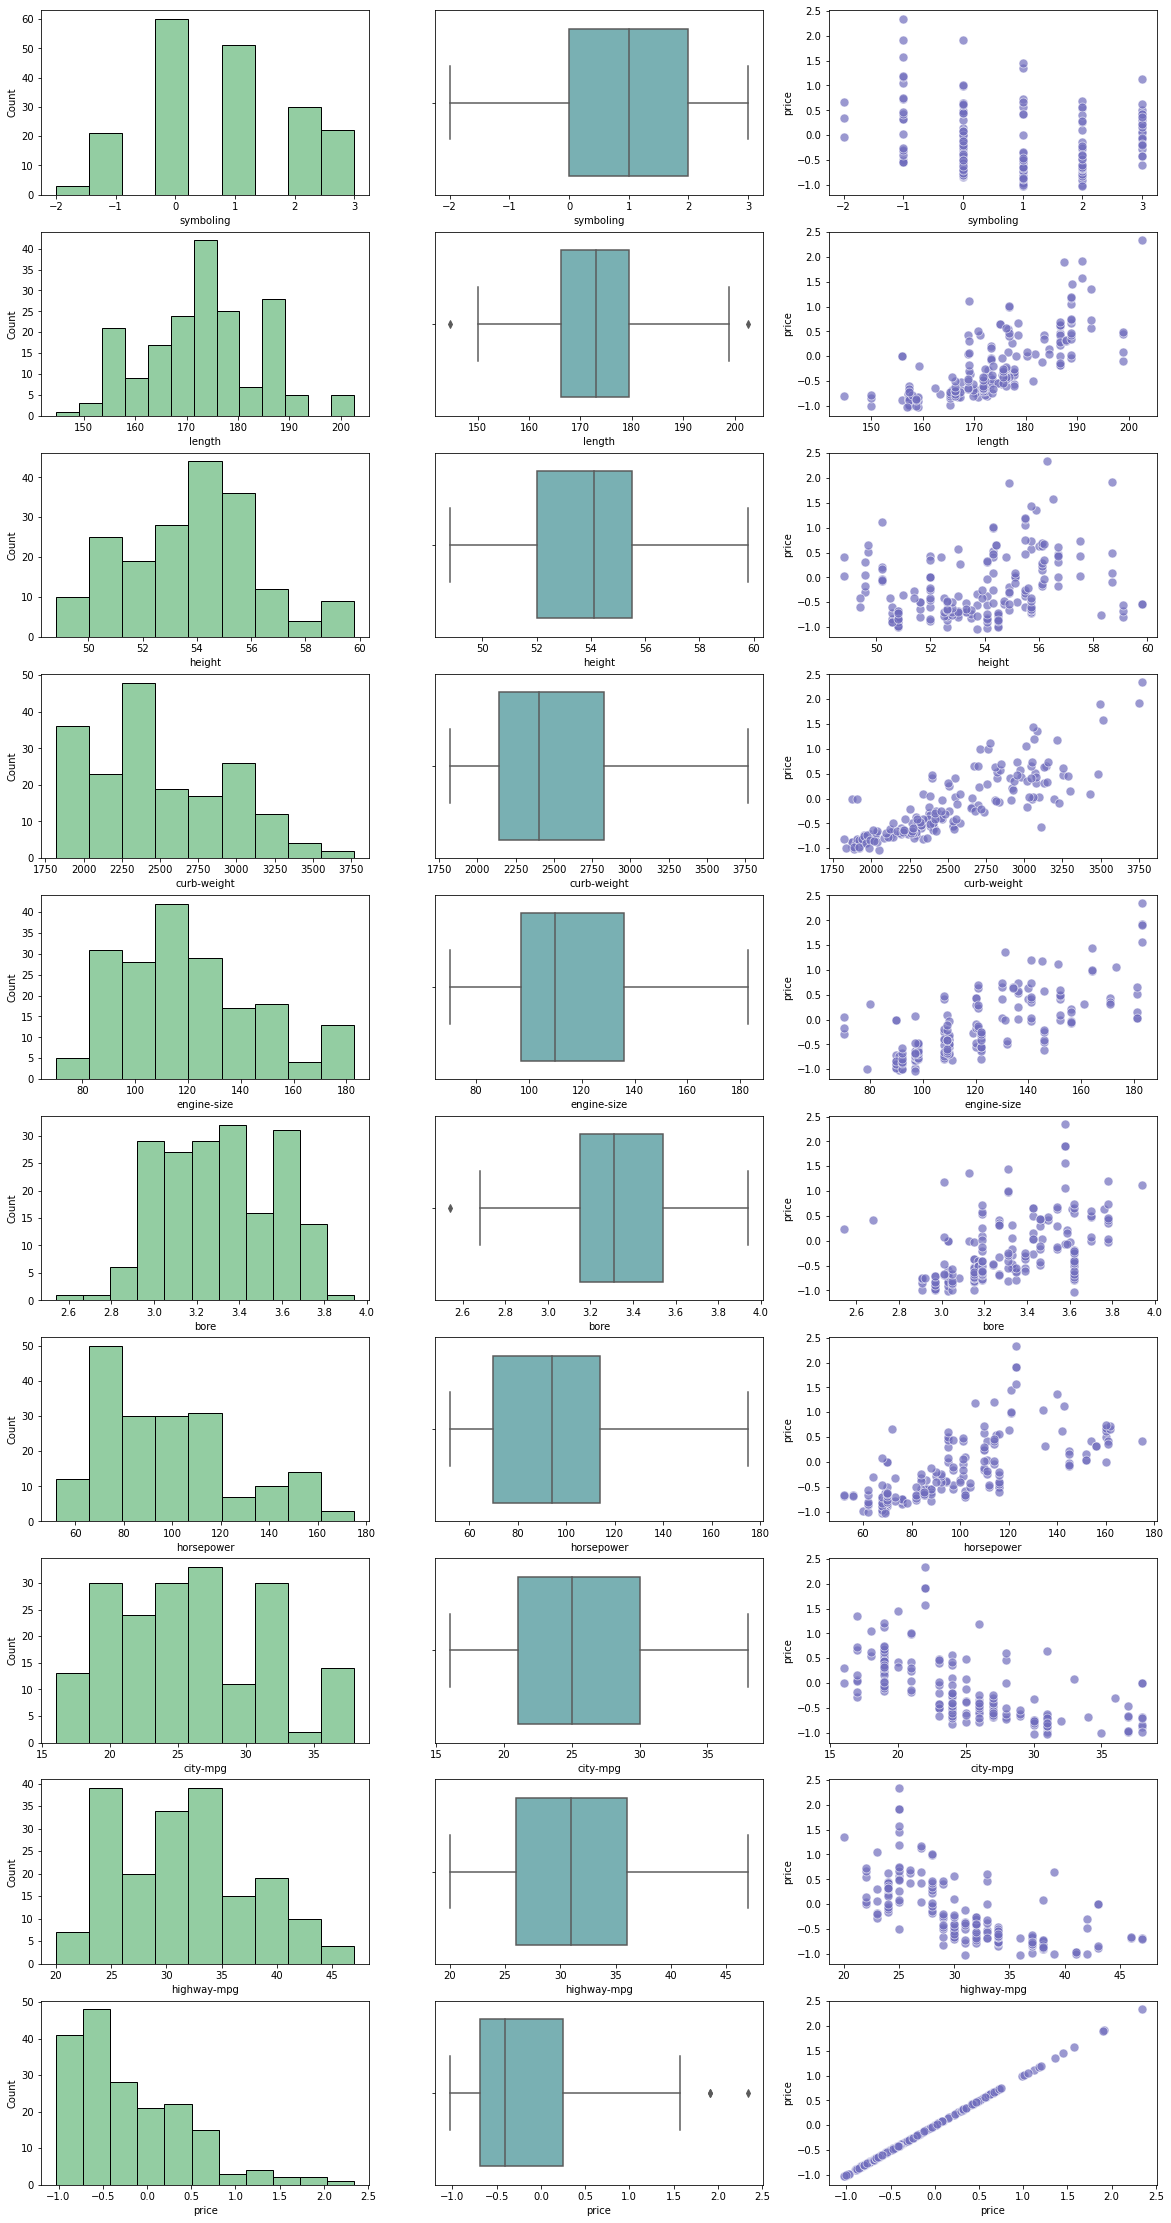

In [33]:
plot_base_relation(continuous_df, (20, 40))

In [34]:
get_column_names(continuous_df)

symboling | length | height | curb-weight | engine-size | bore | horsepower | city-mpg | highway-mpg | price | 

`refactor_continuous_nan_columns` not only solves the problem of removing nan but also remove columns that have low correlation with `price` column

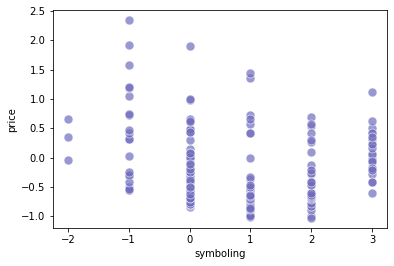

In [35]:
# symboling

# refactor_continuous_nan_columns(continuous_df, 'symboling', scale_func=standard_scaler)
plot_scatterplot(continuous_df.symboling, continuous_df.price)

,-2,-1,0,1,2,3
182,0,0,0,0,1,0
38,0,0,1,0,0,0
137,0,0,0,0,1,0
202,0,1,0,0,0,0
84,0,0,0,0,0,1


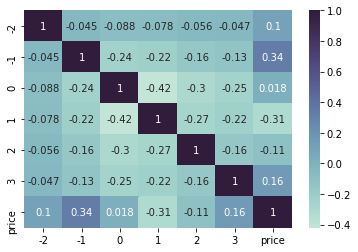

In [36]:
# symboling

# `symboling` is a categorical column with discret numeric data

symboling_dummies = pd.get_dummies(continuous_df.symboling)

sns.heatmap(
    pd.concat([symboling_dummies, continuous_df.price], axis='columns').corr(), 
    annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
)

# during eda of `categorical_df` concat `symboling_dummies` with `categorical_df`
# `-1` column of `symboling_dummies` has some correlation with `price` as compared
# to others

continuous_df.drop(['symboling'], axis='columns', inplace=True)

symboling_dummies.sample(5)

Pearson corr: 0.73
Average length value: 173.34
False


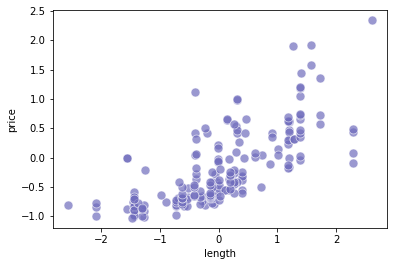

In [37]:
# length
refactor_continuous_nan_columns(continuous_df, 'length', scale_func=standard_scaler)
# The `length` column has a moderate corr with price column

Pearson corr: 0.28
height has been dropped


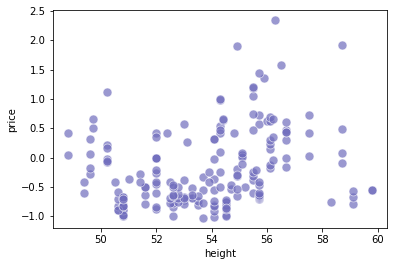

In [38]:
# height
refactor_continuous_nan_columns(continuous_df, 'height', scale_func=standard_scaler)

Pearson corr: 0.84
Average curb-weight value: 2495.29
False


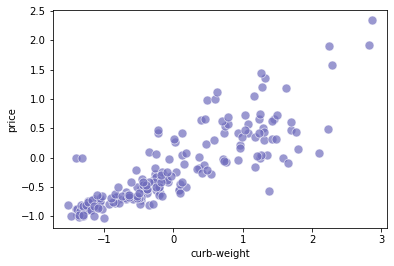

In [39]:
# curb-weight
refactor_continuous_nan_columns(continuous_df, 'curb-weight', scale_func=standard_scaler)

Pearson corr: 0.74
Average engine-size value: 118.96
False


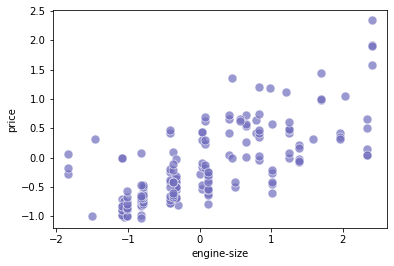

In [40]:
# engine-size
refactor_continuous_nan_columns(continuous_df, 'engine-size', scale_func=standard_scaler)

Pearson corr: 0.48
bore has been dropped


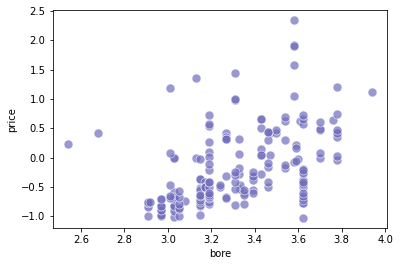

In [41]:
refactor_continuous_nan_columns(continuous_df, 'bore', scale_func=standard_scaler)

Pearson corr: 0.69
Average horsepower value: 97.67
False


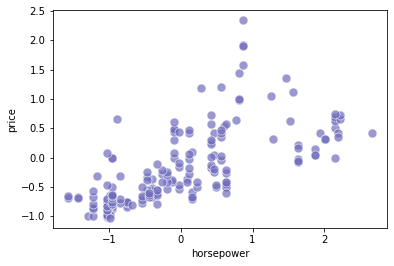

In [42]:
refactor_continuous_nan_columns(continuous_df, 'horsepower', scale_func=standard_scaler)

Pearson corr: -0.64
Average city-mpg value: 25.64
False


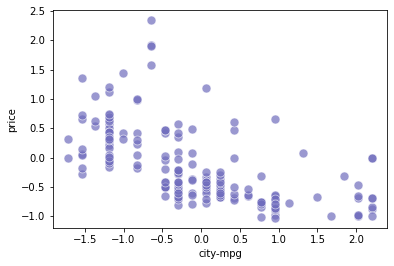

In [43]:
refactor_continuous_nan_columns(continuous_df, 'city-mpg', scale_func=standard_scaler)

Pearson corr: -0.66
Average highway-mpg value: 31.2
False


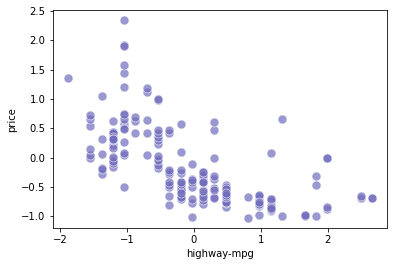

In [44]:
refactor_continuous_nan_columns(continuous_df, 'highway-mpg', scale_func=standard_scaler)

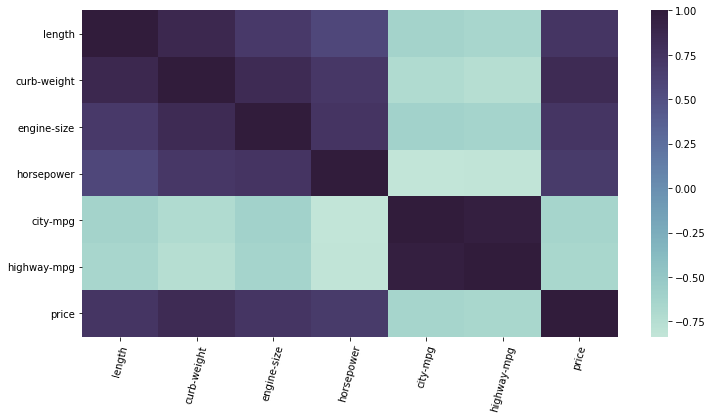

In [45]:
def plot_corr(df):
    # the `corr` method uses pearson correaltion
    corr = df.corr()
    
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    g = sns.heatmap(corr, ax=ax, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

    for _ax in g.get_xticklabels():
        _ax.set_rotation(75)
    
    
plot_corr(continuous_df)

Looking at above heatmap we can say that many columns are highly correlated with other columns (other than `price`) this brings `multicollinearity`. [Source](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea) to understand more about issue with multicollinearity.

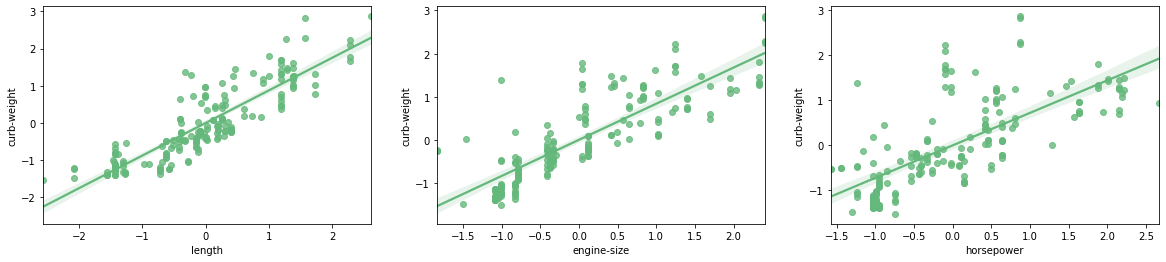

In [46]:
_, ax = plt.subplots(1, 3, figsize=(20, 4))

sns.regplot(x='length', y='curb-weight', data=continuous_df, color='#65b87b', ax=ax[0])
sns.regplot(x='engine-size', y='curb-weight', data=continuous_df, color='#65b87b', ax=ax[1])
sns.regplot(x='horsepower', y='curb-weight', data=continuous_df, color='#65b87b', ax=ax[2])

# length, engine-size & horsepower are highly correlated to curb-weight & thus
# causing multicollinearity issue, so dropping any of these 4 columns

drop_column(continuous_df, 'length')
drop_column(continuous_df, 'engine-size')
drop_column(continuous_df, 'horsepower')

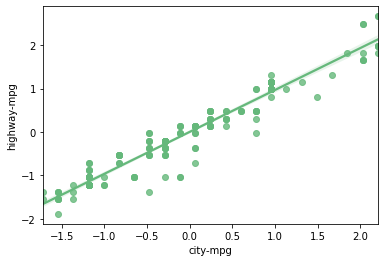

In [47]:
sns.regplot(x='city-mpg', y='highway-mpg', data=continuous_df, color='#65b87b')

# city-mpg is highly correlated to highway-mpg & thus causing multicollinearity 
# issue, so dropping any of these 1 columns

drop_column(continuous_df, 'highway-mpg')

In [48]:
continuous_df.sample(5)

,curb-weight,city-mpg,price
57,-0.248023,-1.540770,0.055783
101,1.348660,-1.540770,0.037183
149,0.347922,-0.470340,-0.192766
176,-0.182806,0.243279,-0.294173
33,-1.248761,0.778494,-0.850766


### Categorical Variables

In [49]:
categorical_df = get_categorical_df(df)
categorical_df.sample(5)

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
187,volkswagen,diesel,turbo,four,sedan,fwd,front,ohc,four,idi
158,toyota,diesel,std,four,sedan,fwd,front,ohc,four,idi
193,volkswagen,gas,std,four,wagon,fwd,front,ohc,four,mpfi
195,volvo,gas,std,four,wagon,rwd,front,ohc,four,mpfi
29,dodge,gas,turbo,two,hatchback,fwd,front,ohc,four,mfi


In [50]:
len(original_y)

187

In [51]:
print(f'Original categorica_df size: {len(categorical_df)}')

# Removing rows which were removed in `continuous_df`
categorical_df = categorical_df.drop(RM_ROWS_IDXS, axis='rows')

# Adding `SalePrice` column
categorical_df = pd.concat([categorical_df, original_y], axis='columns')

print(f'New categorica_df size: {len(categorical_df)}')

categorical_df.sample(5)

Original categorica_df size: 205
New categorica_df size: 187


,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system,price
93,nissan,gas,std,four,wagon,fwd,front,ohc,four,2bbl,7349.0
102,nissan,gas,std,four,wagon,fwd,front,ohcv,six,mpfi,14399.0
21,dodge,gas,std,two,hatchback,fwd,front,ohc,four,2bbl,5572.0
193,volkswagen,gas,std,four,wagon,fwd,front,ohc,four,mpfi,12290.0
144,subaru,gas,std,four,sedan,4wd,front,ohcf,four,2bbl,9233.0


In [52]:
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 204
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   make              187 non-null    object 
 1   fuel-type         187 non-null    object 
 2   aspiration        187 non-null    object 
 3   num-of-doors      187 non-null    object 
 4   body-style        187 non-null    object 
 5   drive-wheels      187 non-null    object 
 6   engine-location   187 non-null    object 
 7   engine-type       187 non-null    object 
 8   num-of-cylinders  187 non-null    object 
 9   fuel-system       187 non-null    object 
 10  price             187 non-null    float64
dtypes: float64(1), object(10)
memory usage: 17.5+ KB


In [53]:
def plot_countplot(df, column_name, ax=None):
    _df = df[[column_name]].copy()
    if len(_df[_df[column_name].isnull()]):
        _df.fillna('NaN', inplace=True)
    
    color = '#42b0f5' if ax != None else '#7661ff'
    sns.countplot(x=column_name, data=_df, color=color, alpha=.7, ax=ax)
    del _df

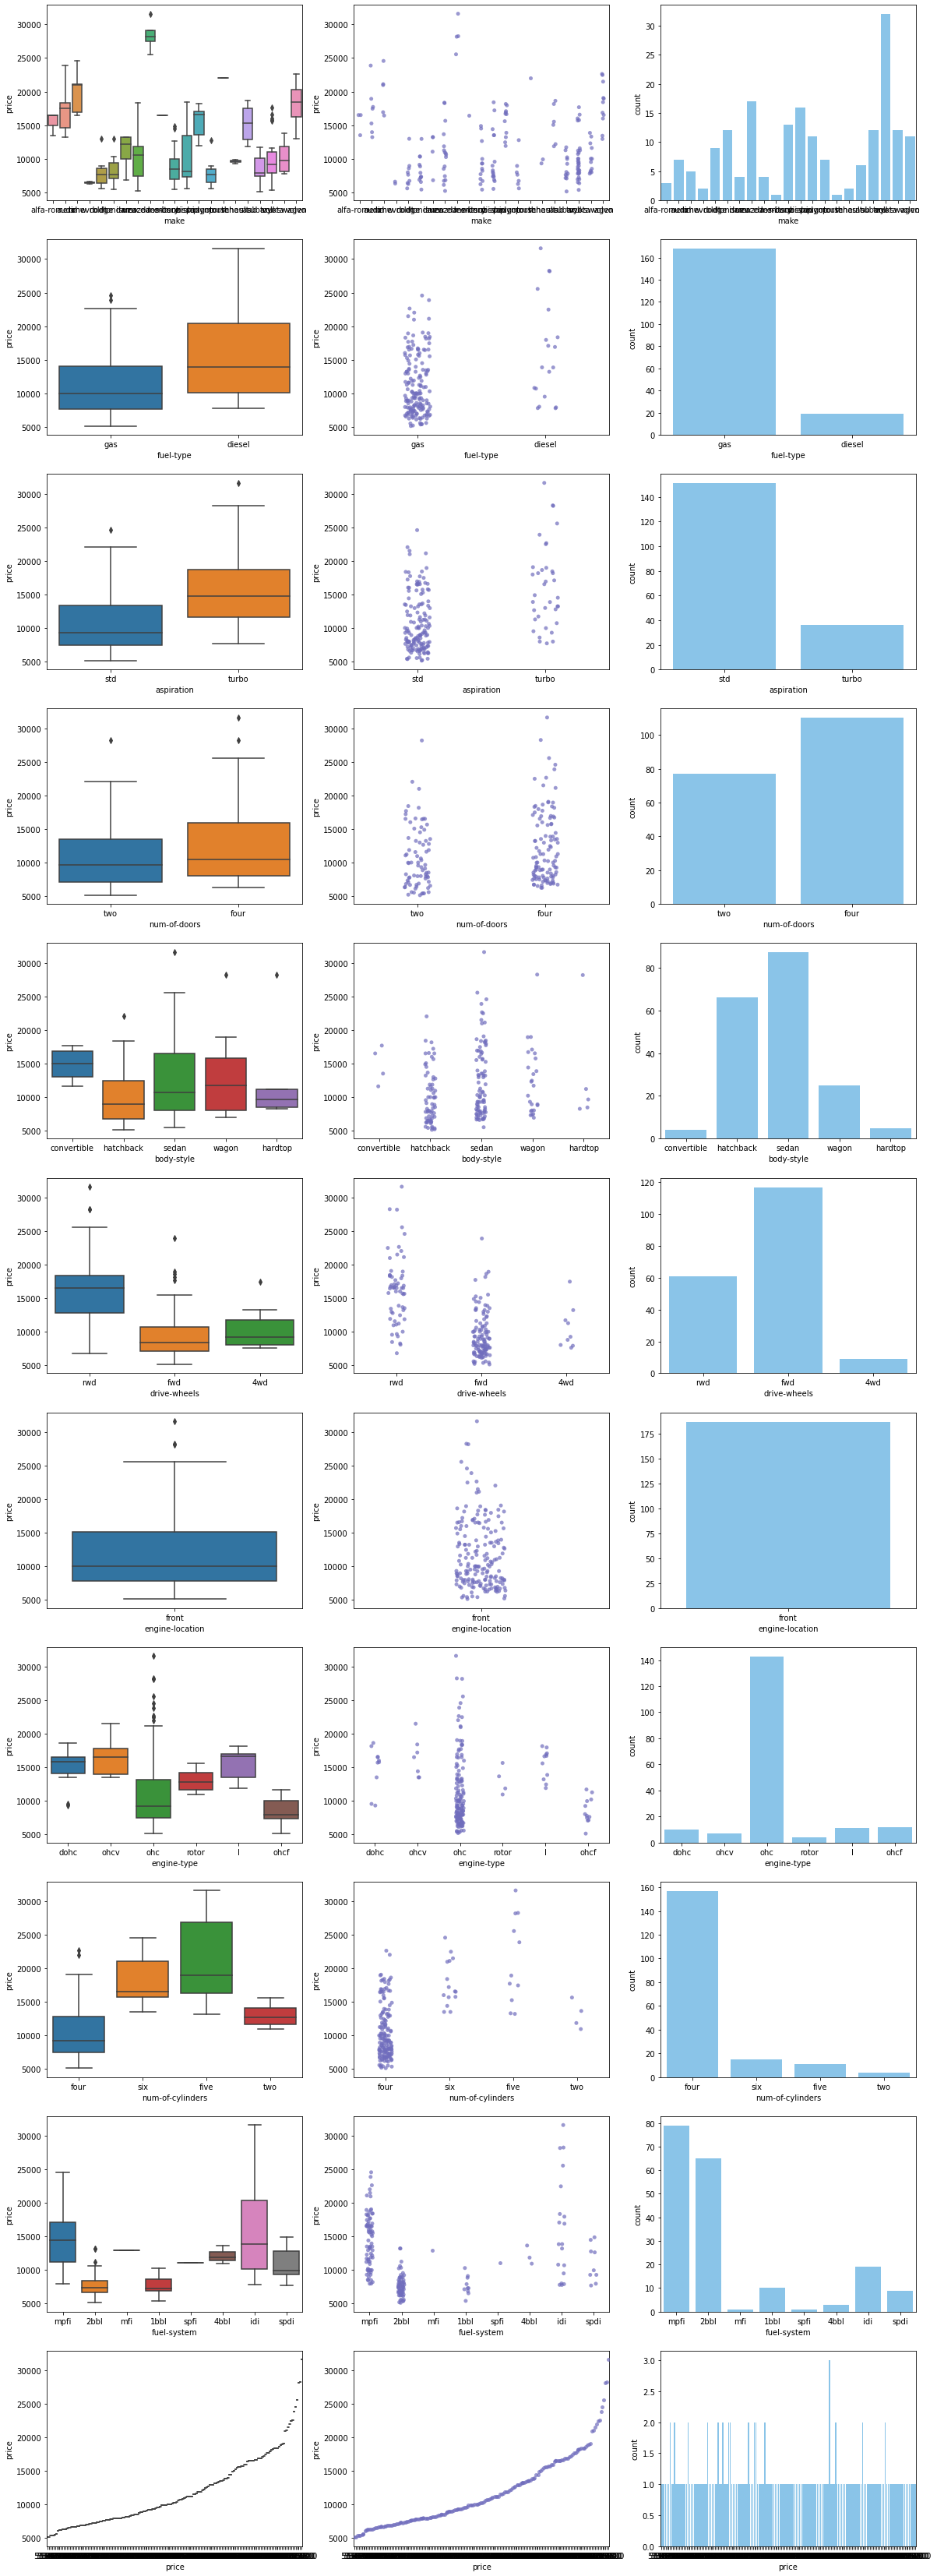

In [54]:
def plot_base_categorical_relation(df, figsize=(20, 60)):
    columns = df.columns.tolist()
    _, axs = plt.subplots(len(columns), 3, figsize=figsize)
    
    for idx, column in enumerate(columns):
        try:
            # To get knowledge about outliers & distribution
            sns.boxplot(x=df[column], y=df['price'], ax=axs[idx][0])

            # To get its realtion with SalePrice
            sns.stripplot(
                x=column, y='price', data=df,
                color='#706dbd', alpha=.7, jitter=.1,
                ax=axs[idx][1]
            )

            # To get count plot for `column` (considering NaN, so we can know 
            # how much of data is missing)
            plot_countplot(df, column, axs[idx][2])
        except ValueError:
            # ValueError: min() arg is an empty sequence
            # 
            # The above error happens while creating plot for column `PoolQC` (maybe 
            # because it has NaN value)
            print(f'{column} cannot be plotted')
        
        
plot_base_categorical_relation(categorical_df)

In [55]:
get_column_names(categorical_df)

make | fuel-type | aspiration | num-of-doors | body-style | drive-wheels | engine-location | engine-type | num-of-cylinders | fuel-system | price | 

In [56]:
# front

print(categorical_df['engine-location'].unique())
# looking at above plot, `engine-location` has only one value `front` so dropping the column

drop_column(categorical_df, 'engine-location')

['front']


In [57]:
def plot_base_categorical_realtion_for_column(df, column_name, figsize=(20, 20)):
    _, ax = plt.subplots(3, 1, figsize=figsize)
    # To get knowledge about outliers & distribution
    sns.boxplot(x=df[column_name], y=df['price'], ax=ax[0])

    # To get its realtion with price
    sns.stripplot(
        x=column_name, y='price', data=df,
        color='#706dbd', alpha=.7, jitter=.2,
        ax=ax[1]
    )

    # To get count plot for `column` (considering NaN, so we can know 
    # how much of data is missing)
    plot_countplot(df, column_name, ax[2])

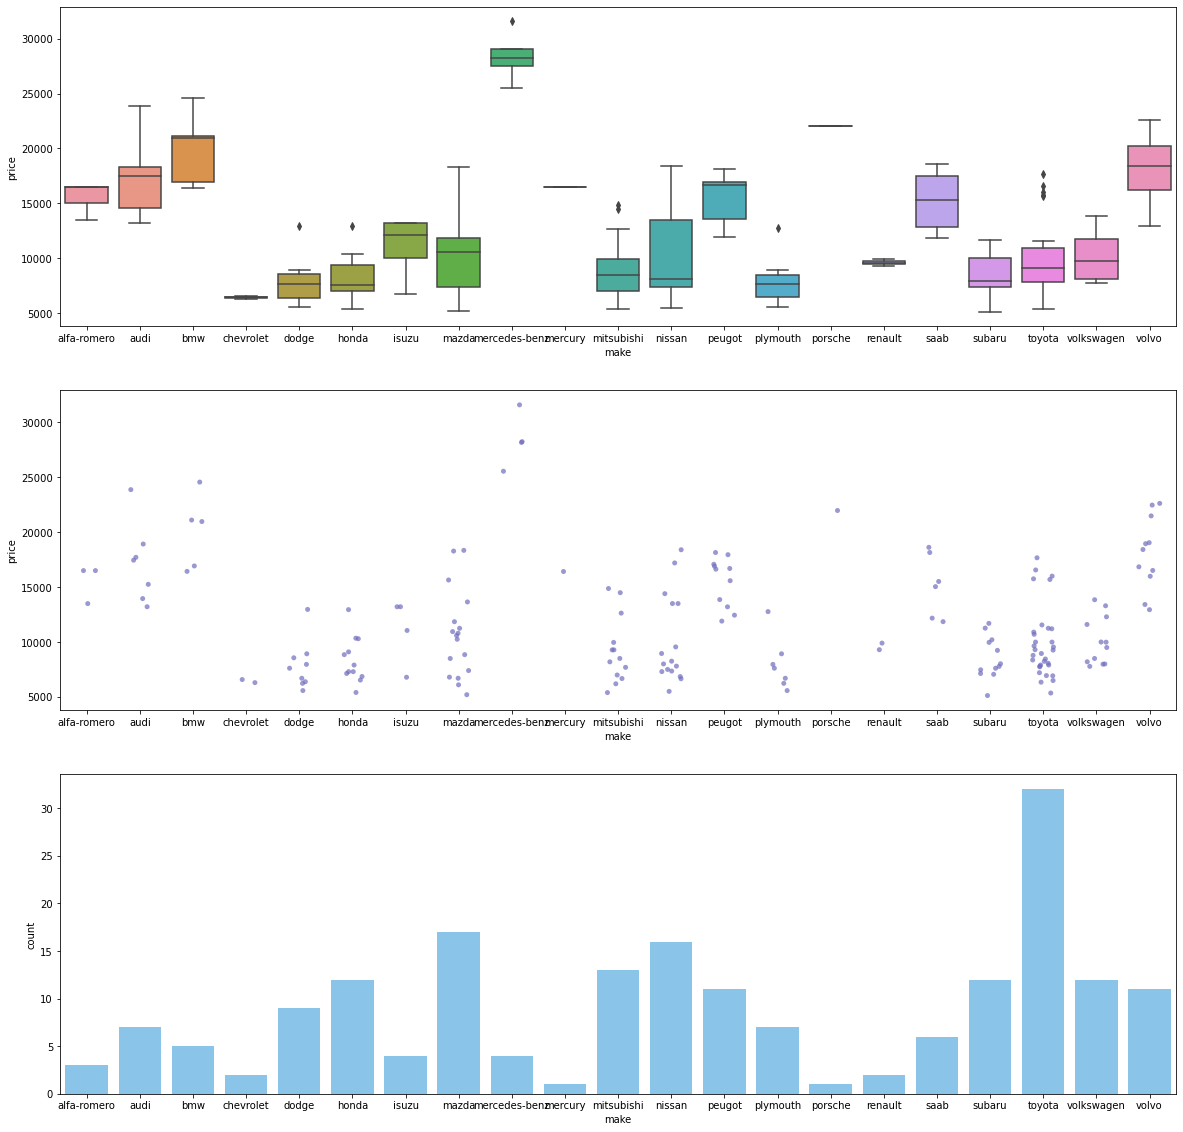

In [58]:
plot_base_categorical_realtion_for_column(categorical_df, 'make')

In [59]:
# Categorical variable column correlation with one continuous variable column
def cat_corr_with_one_cont_column(df, column_name, cont_column_name='price', ax=None):
    _, ax = plt.subplots(1, 2, figsize=(20, 4))
    
    # Correlation plot
    dummies = pd.concat(
        [pd.get_dummies(df[column_name]), df[cont_column_name]],
        axis='columns'
    )
    corr = dummies.corr()[[cont_column_name]].sort_values(by=cont_column_name, ascending=False)
    sns.heatmap(corr, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax[0])
    ax[0].set_title(column_name)
    
    # Box plot
    sns.barplot(x=column_name, y=cont_column_name, data=df, palette='rocket', ax=ax[1])
    ax[1].set_title(column_name)

In [60]:
# creating a one hot encoded df before chaning values & later will join 
# both of them with `continuous_df` and do modelling on both the datasets

def onehotencode_categorical_df(df):
    columns = df.columns.tolist()
    dummies = pd.DataFrame()
    
    for column in columns:
        if column != 'price':
            dummies = pd.concat(
                [dummies, pd.get_dummies(df[column])],
                axis='columns'
            )
        else:
            dummies = pd.concat([dummies, df[column]], axis='columns')

    return dummies

categorical_dummies_df = onehotencode_categorical_df(categorical_df)
categorical_dummies_df.sample(5)

,alfa-romero,audi,bmw,chevrolet,dodge,honda,isuzu,mazda,mercedes-benz,mercury,mitsubishi,nissan,peugot,plymouth,porsche,renault,saab,subaru,toyota,volkswagen,volvo,diesel,gas,std,turbo,four,two,convertible,hardtop,hatchback,sedan,wagon,4wd,fwd,rwd,dohc,l,ohc,ohcf,ohcv,rotor,five,four,six,two,1bbl,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,price
184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,7995.000000
100,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9549.000000
24,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,6229.000000
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,13207.129353
204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,22625.000000


In [61]:
def update_categorical_with_numeric_values(df, column_name, new_values):
    # In new values, rank the categorical value with its influence on 
    # `SalePrice`. eg. if a has less influence on SalePrice than b then 
    # new_value = {
    #   'a': 0,
    #   'b': 1
    # }
    # a => 0 since it has less influence than b => 1
    
    df[column_name] = df[column_name].apply(lambda current_value: new_values[current_value])

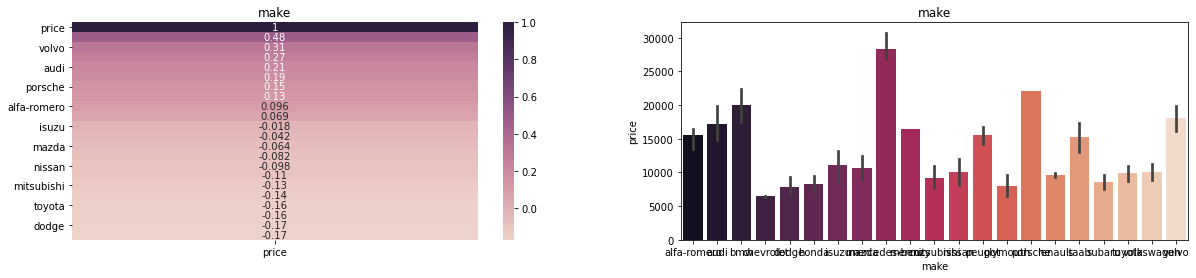

In [62]:
cat_corr_with_one_cont_column(categorical_df, 'make')

# Ranking 
new_values = {
    'chevrolet': 0,
    'dodge': 1,
    'honda': 2,
    'plymouth': 2,
    'subaru': 2,
    'mitsubishi': 3,
    'renault': 4,
    'toyota': 4,
    'volkswagen': 4,
    'mazda': 5,
    'isuzu': 6,
    'nissan': 7,
    'saab': 8,
    'peugot': 9,
    'alfa-romero': 10,
    'mercury': 11,
    'volvo': 12,
    'audi': 13,
    'bmw': 14,
    'porsche': 15,
    'mercedes-benz': 16
}
update_categorical_with_numeric_values(categorical_df, 'make', new_values)

<AxesSubplot:xlabel='make', ylabel='price'>

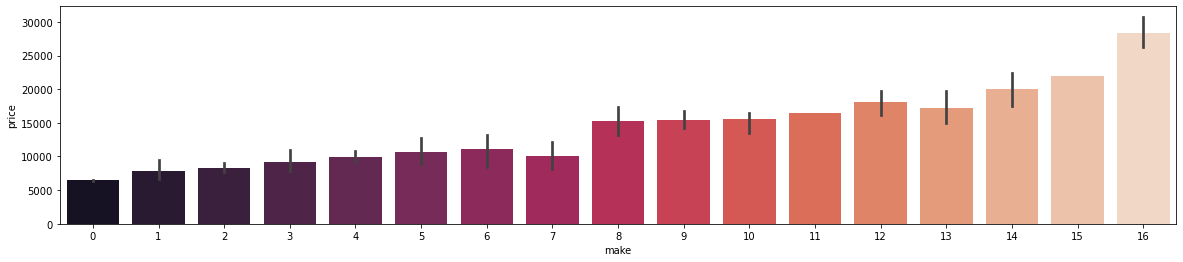

In [63]:
# make
_, ax = plt.subplots(figsize=(20, 4))
sns.barplot(x=categorical_df.make, y=categorical_df.price, palette='rocket', ax=ax)

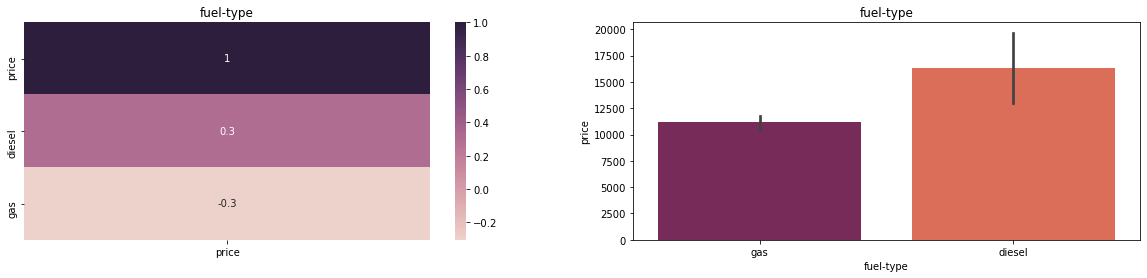

In [64]:
cat_corr_with_one_cont_column(categorical_df, 'fuel-type')

new_values = {
    'gas': 0,
    'diesel': 1
}
update_categorical_with_numeric_values(categorical_df, 'fuel-type', new_values)

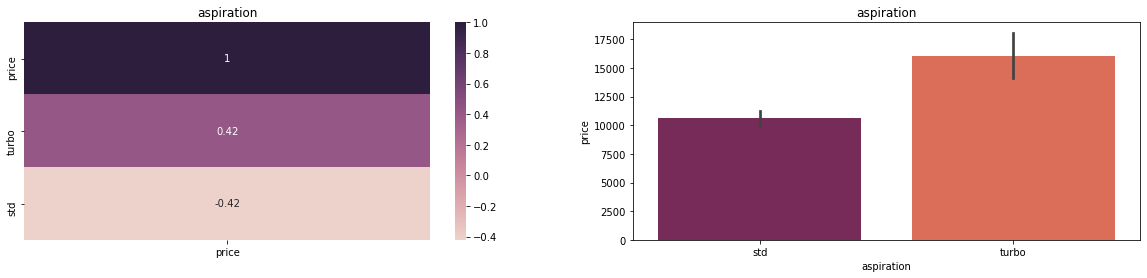

In [65]:
cat_corr_with_one_cont_column(categorical_df, 'aspiration')

new_values = {
    'std': 0,
    'turbo': 1
}
update_categorical_with_numeric_values(categorical_df, 'aspiration', new_values)

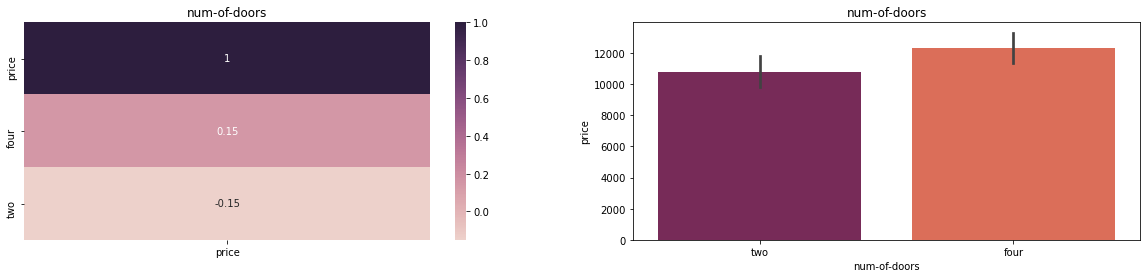

In [66]:
cat_corr_with_one_cont_column(categorical_df, 'num-of-doors')

new_values = {
    'two': 0,
    'four': 1
}
update_categorical_with_numeric_values(categorical_df, 'num-of-doors', new_values)

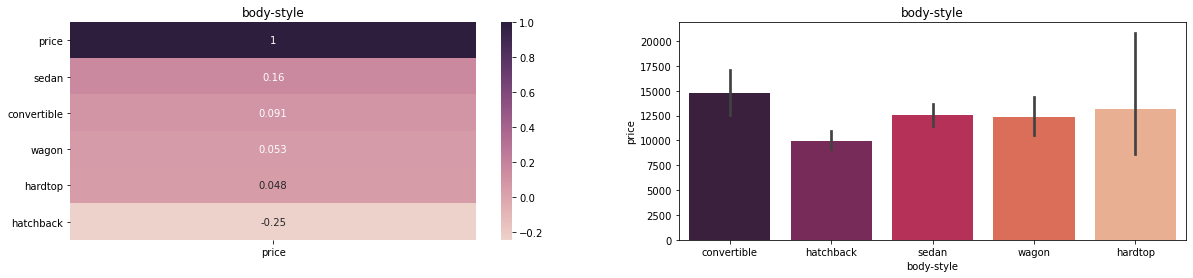

In [67]:
cat_corr_with_one_cont_column(categorical_df, 'body-style')
drop_column(categorical_df, 'body-style') # since its categories have very low correlations

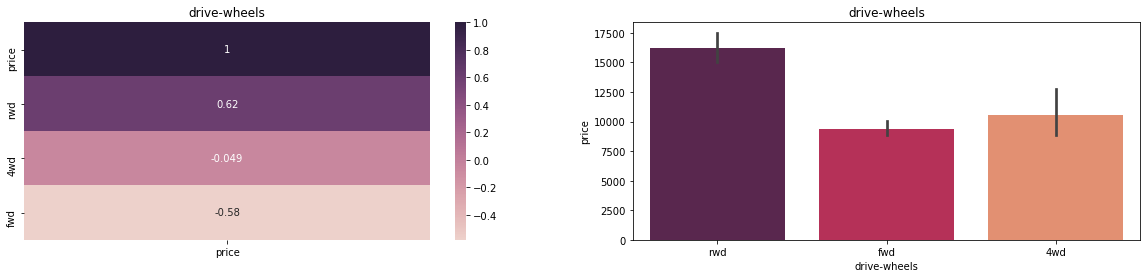

In [68]:
cat_corr_with_one_cont_column(categorical_df, 'drive-wheels')

new_values = {
    'fwd': 0,
    '4wd': 1,
    'rwd': 2
}
update_categorical_with_numeric_values(categorical_df, 'drive-wheels', new_values)

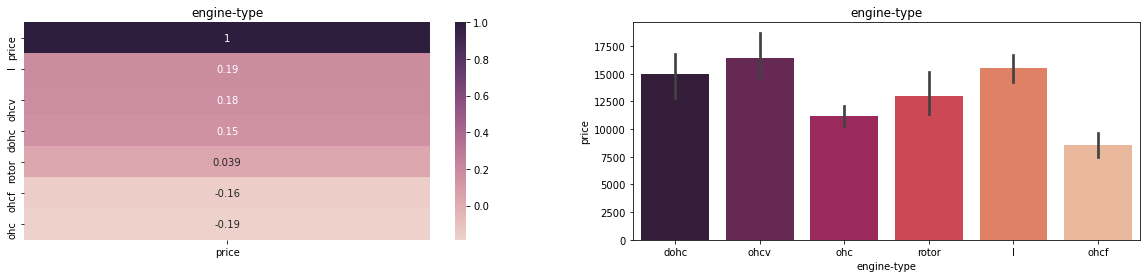

In [69]:
cat_corr_with_one_cont_column(categorical_df, 'engine-type')

new_values = {
    'ohcf': 0,
    'ohc': 1,
    'rotor': 2,
    'l': 3,
    'dohc': 4,
    'ohcv': 5
}
update_categorical_with_numeric_values(categorical_df, 'engine-type', new_values)

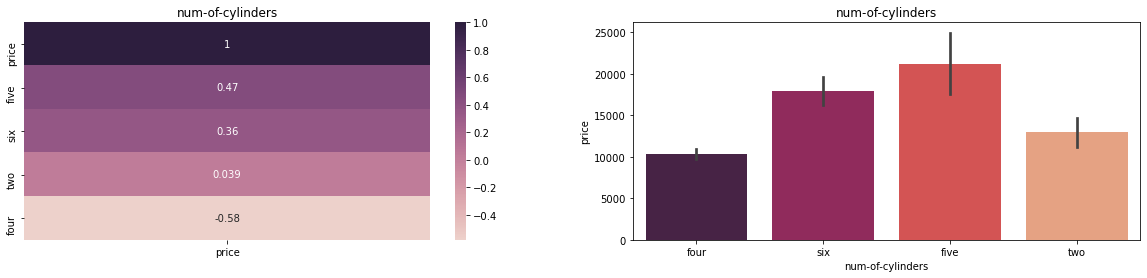

In [70]:
cat_corr_with_one_cont_column(categorical_df, 'num-of-cylinders')

new_values = {
    'four': 0,
    'two': 1,
    'six': 2,
    'five': 3
}
update_categorical_with_numeric_values(categorical_df, 'num-of-cylinders', new_values)

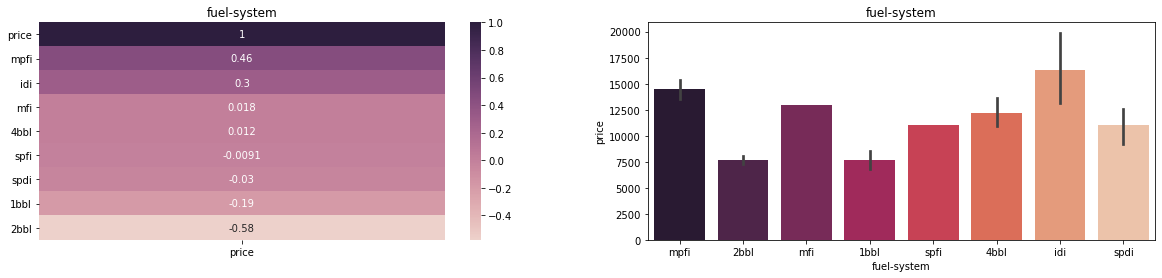

In [71]:
cat_corr_with_one_cont_column(categorical_df, 'fuel-system')

new_values = {
    '2bbl': 0,
    '1bbl': 1,
    'spfi': 2,
    'spdi': 3,
    '4bbl': 4,
    'mfi': 5,
    'mpfi': 6,
    'idi': 7
}
update_categorical_with_numeric_values(categorical_df, 'fuel-system', new_values)

## Modelling

In [72]:
# below `categorical_df` is used instead of `categorical_dummies_df`

scaling_df(categorical_df)

# dropping price column since we are using the not scaled price
categorical_df.drop(['price'], axis='columns', inplace=True)
continuous_df.drop(['price'], axis='columns', inplace=True)

# Combining both the dataframes & price column
dataset_df = pd.concat([continuous_df, categorical_df, original_y], axis='columns')
dataset_df.sample(5)

,curb-weight,city-mpg,make,fuel-type,aspiration,num-of-doors,drive-wheels,engine-type,num-of-cylinders,fuel-system,price
134,0.476107,-0.827150,0.576565,-0.336296,-0.488273,-1.195229,-0.754445,-0.343990,-0.415580,0.841145,15040.000000
181,1.474596,-1.183960,-0.447831,-0.336296,-0.488273,0.836660,1.399467,2.336266,1.904226,0.841145,15750.000000
142,-0.686549,0.421684,-0.960029,-0.336296,-0.488273,0.836660,-0.754445,-1.237409,-0.415580,-1.214987,7775.000000
84,0.968605,-1.183960,-0.703930,-0.336296,2.048034,-1.195229,-0.754445,-0.343990,-0.415580,-0.186921,14489.000000
9,1.254209,-1.719175,1.857060,-0.336296,2.048034,-1.195229,0.322511,-0.343990,3.064129,0.841145,13207.129353


In [73]:
# instead of `dataset_df` we can also use `dataset_with_dummies_df`
columns = dataset_df.columns.tolist()
columns.remove('price')

x = np.array(dataset_df[columns].values)
y = np.array(dataset_df['price'].values.reshape(-1, 1))

print(f'Dataset size: {len(x)}')

Dataset size: 187


In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

print(f'Training dataset size: {len(x_train)} i.e. {round(len(x_train) / len(x), 2)}% of dataset')
print(f'Testing dataset size: {len(x_test)} i.e. {round(len(x_test) / len(x), 2)}% of dataset')

Training dataset size: 140 i.e. 0.75% of dataset
Testing dataset size: 47 i.e. 0.25% of dataset


In [75]:
kf = KFold(n_splits=10)

score = cross_val_score(Ridge(), x_train, y_train, cv=kf)
print(f'Ridge: {score.mean()}')

score = cross_val_score(LinearRegression(), x_train, y_train, cv=kf)
print(f'LinearRegression: {score.mean()}')

score = cross_val_score(Lasso(), x_train, y_train, cv=kf)
print(f'Lasso: {score.mean()}')

score = cross_val_score(ElasticNet(), x_train, y_train, cv=kf)
print(f'ElasticNet: {score.mean()}')

Ridge: 0.6823075732770862
LinearRegression: 0.6783615954392188
Lasso: 0.6791215056345351
ElasticNet: 0.7182968120561541


In [76]:
def find_best_params(X, y, cv=10):
    alpha = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
    selection = ['cyclic', 'random']
    
    params = {
        'alpha': alpha,
        'selection': selection
    }
    
    grid_search = GridSearchCV(ElasticNet(), param_grid=params, cv=cv, n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_params_


find_best_params(x_train, y_train, kf)

{'alpha': 1, 'selection': 'cyclic'}

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coo

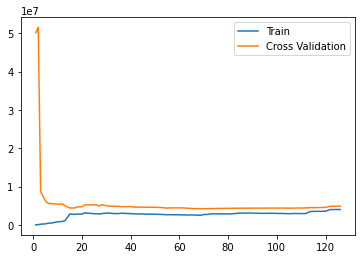

In [77]:
_size = np.arange(0.01, 1.01, 0.01)
train_sizes = np.array(_size)
scoring = 'neg_mean_squared_error'

train_sizes_abs, train_scores, cv_scores = learning_curve(
    ElasticNet(alpha=1, selection='cyclic'), 
    x_train, y_train, train_sizes=train_sizes, 
    cv=kf, scoring=scoring
)

train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)

plt.plot(train_sizes_abs, train_scores_mean, label='Train')
plt.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

plt.legend()

In [78]:
model = ElasticNet(alpha=1, selection='cyclic')
model.fit(x_train, y_train)

ElasticNet(alpha=1)

## Evaluation

In [79]:
# Out-Of-Sample Forecast

y_test_pred = model.predict(x_test)
rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 2424.600005397635
R2-score: 0.7815263573840042


In [80]:
# Saving the model
dump(model, 'model.joblib')

['model.joblib']

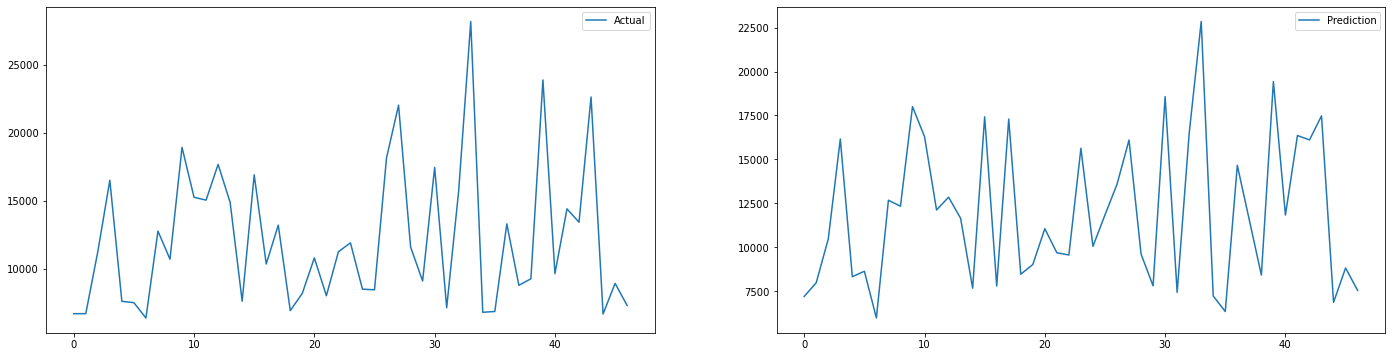

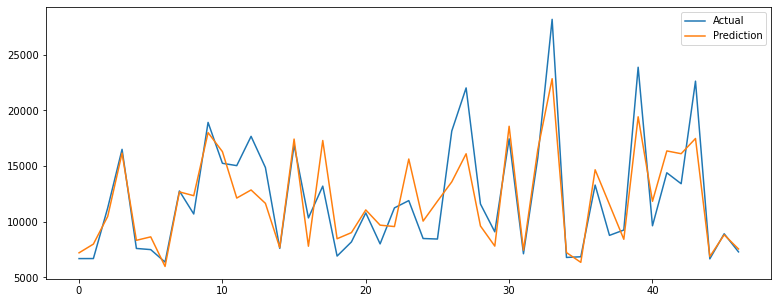

In [81]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

ax1.plot(np.arange(len(y_test)), y_test, label='Actual')
ax2.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

ax3.plot(np.arange(len(y_test)), y_test, label='Actual')
ax3.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax3.legend()

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/At104sWg0sDNYuD6FK/giphy.gif)

---